### Stock Price Prediction using SMA,EMA,BB,RSI,MACD

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mplfinance as mpf
from datetime import timedelta
from matplotlib.dates import WeekdayLocator, MO
import matplotlib.dates as mdates

In [2]:
# Download data
ticker_symbol = "META"
ticker = yf.Ticker(ticker_symbol)
historical_data = ticker.history(period="2y")
df = historical_data.copy()

### Feature Adding(Indicators)

In [3]:
# SMA & EMA
def calculate_sma_ema(df, window=20):
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    return df

In [4]:
#Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std=2):
    df['SMA_20'] = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()

    df['UPPER_BAND'] = df['SMA_20'] + (num_std * rolling_std)
    df['LOWER_BAND'] = df['SMA_20'] - (num_std * rolling_std)

    return df

In [5]:
#Relative Strength Index
def calculate_rsi(df, period):
    delta = df['Close'].diff()  # price change between consecutive days

    gain = delta.where(delta > 0, 0)  # replace negative values by 0
    loss = -delta.where(delta < 0, 0)  # replace positive values by 0 and take absolute

    # Calculate average gain and loss using exponential moving average (EMA)
    avg_gain = gain.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df[f'RSI_{period}'] = rsi
    return df

In [6]:
# MACD
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    # Calculate the short and long EMAs
    ema_short = df['Close'].ewm(span=short_period, adjust=False).mean()
    ema_long = df['Close'].ewm(span=long_period, adjust=False).mean()

    # Calculate MACD line
    df['MACD'] = ema_short - ema_long

    # Calculate Signal line
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    return df

In [8]:
# Hull Moving Average
def calculate_hma(df, window=20):

    def wma(series, period):
        weights = np.arange(1, period + 1)
        return series.rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

    half_length = int(window / 2)
    sqrt_length = int(np.sqrt(window))

    wma_half = wma(df['Close'], half_length)
    wma_full = wma(df['Close'], window)

    diff = 2 * wma_half - wma_full
    hma = wma(diff, sqrt_length)

    col_name = f'HMA_{window}'
    df[col_name] = hma

    return df


In [9]:
# Making Indicator Features
df = calculate_sma_ema(df, window=20)
df = calculate_bollinger_bands(df)
df = calculate_rsi(df, period=14)
df = calculate_macd(df)
df = calculate_hma(df, window=20)


### Cleaning

In [10]:
#No use cause they are empty
# print(df['Dividends'].unique())
# print(df['Stock Splits'].unique())
# df.drop(['Dividends','Stock Splits'],axis=1,inplace=True)
if 'Dividends' in df.columns and 'Stock Splits' in df.columns:
    df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

In [17]:
df.sample(5)

,Open,High,Low,Close,Volume,SMA_20,EMA_20,UPPER_BAND,LOWER_BAND,RSI_14,MACD,MACD_Signal,MACD_Hist,HMA_20
Date,,,,,,,,,,,,,,
2025-03-03 00:00:00-05:00,672.110026,679.662392,649.323288,653.523438,10843800,695.385184,677.860861,746.751443,644.018924,42.109241,1.096535,10.448605,-9.352070,655.742121
2024-04-15 00:00:00-04:00,514.098942,515.899820,494.757578,497.692627,13512900,503.404498,503.299824,526.164119,480.644878,49.546378,8.109519,9.446469,-1.336951,518.671074
2024-09-10 00:00:00-04:00,506.084379,512.079779,497.987582,502.728149,9899000,518.816643,510.599697,539.371983,498.261302,45.906393,0.714541,4.126121,-3.411580,503.845320
2024-07-16 00:00:00-04:00,499.451590,501.891595,483.805767,487.789429,14075800,508.145413,505.438438,536.002413,480.288413,42.433386,3.493867,7.509771,-4.015904,513.977703
2024-08-02 00:00:00-04:00,487.002652,499.103018,474.205132,486.146179,24044700,485.620300,482.113334,533.949744,437.290857,50.692250,-5.820313,-6.706379,0.886065,465.242924


### Training And Predicting

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [30]:
# Create target variable
df['Target'] = df['Close'].shift(-1)

# Drop rows with NaN (only the last row will have NaN in Target)
df = df.dropna()

# Define features (consider including 'Close' as a feature)
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20',
                'UPPER_BAND', 'LOWER_BAND', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist','HMA_20']

# Create feature matrix and target vector
X = df[feature_cols]
y = df['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

# Parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Parameter grid for Ridge regression
ridge_param_grid = {
    'alpha': [0.1, 1.0, 10, 50,100,200,500,1000],
    'solver': ['auto', 'svd', 'cholesky']
}
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 10, 100]  # L2 regularization
}
# Train model
# model = Ridge()
# param_grid = ridge_param_grid

model = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = xgb_param_grid

# model = RandomForestRegressor(random_state=42)
# param_grid = rf_param_grid

# Set up GridSearchCV with the selected model and param grid
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (MSE):", -grid_search.best_score_)

# Use best estimator for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Add predictions to DataFrame
df.loc[X_test.index, 'Predicted_Close'] = y_pred

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}
Best CV Score (MSE): 792.2396537668967


### Evaluation

Mean Squared Error (MSE): 340.8628
Mean Absolute Error (MAE): 14.2179
R-squared (R2): 0.1079


C:\Users\vatsa\AppData\Local\Temp\ipykernel_19256\1887327263.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


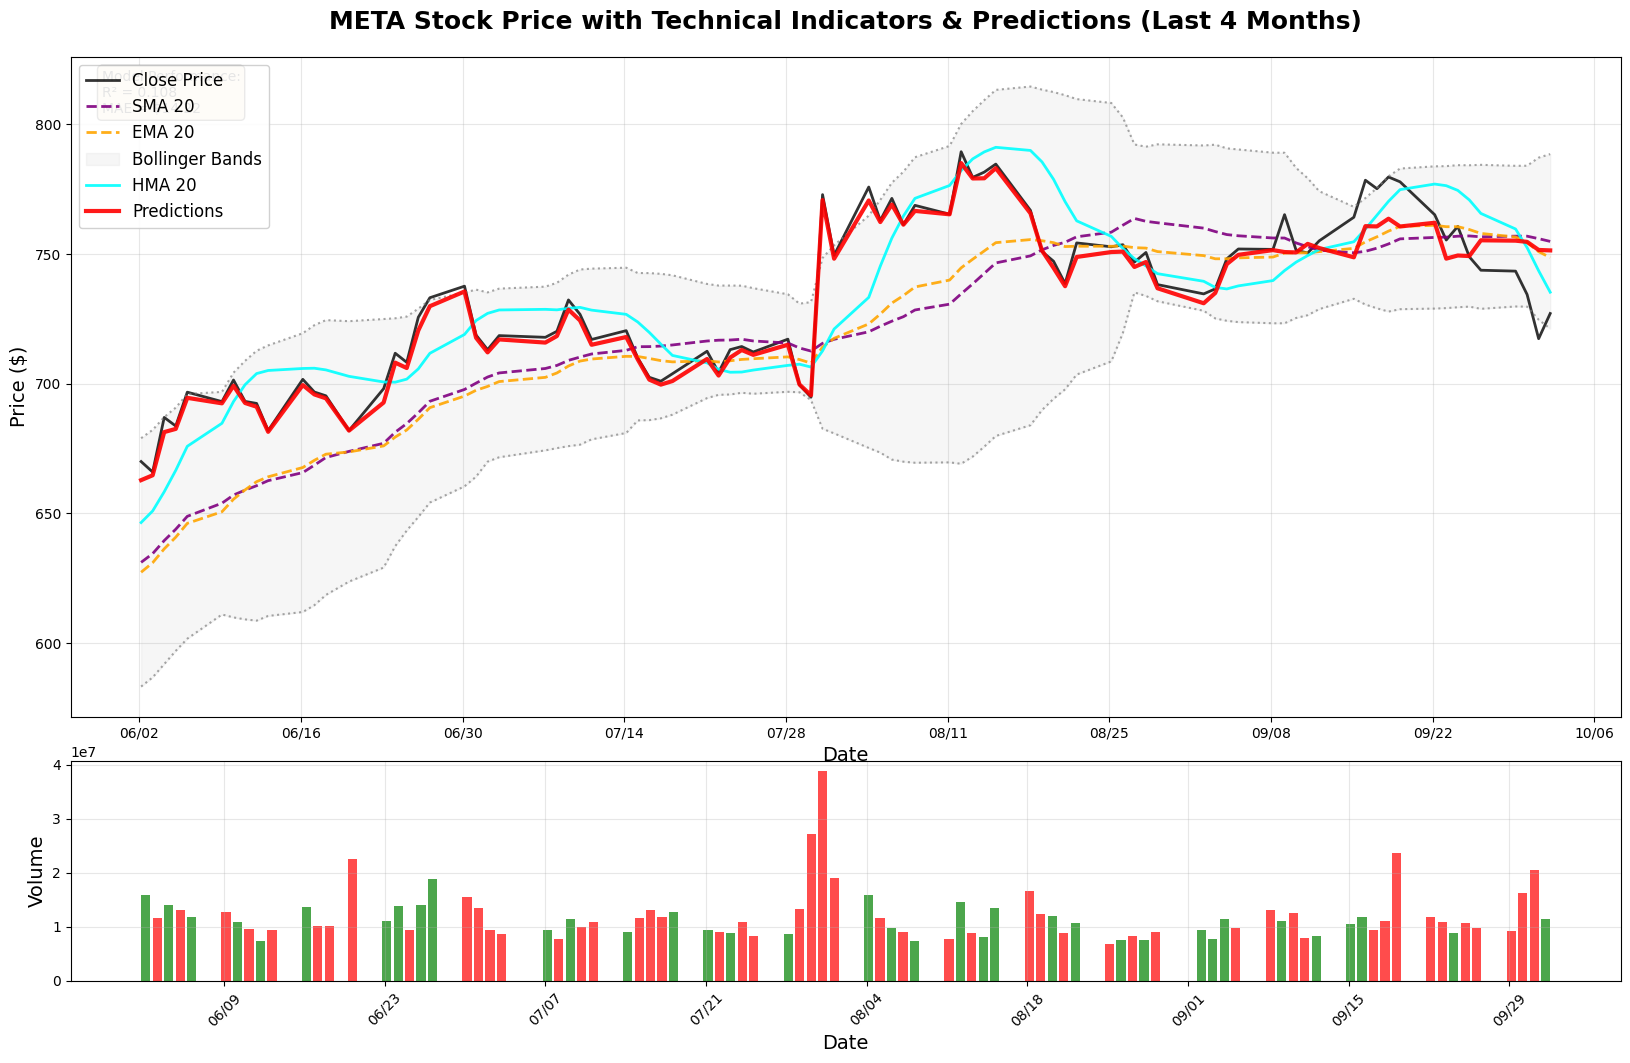


PREDICTION ANALYSIS
Most recent prediction date: 2025-10-02
Predicted price: $751.40
Actual price: $727.05
Prediction error: $24.35 (3.3%)
Prediction coverage: 100.0% of total data points


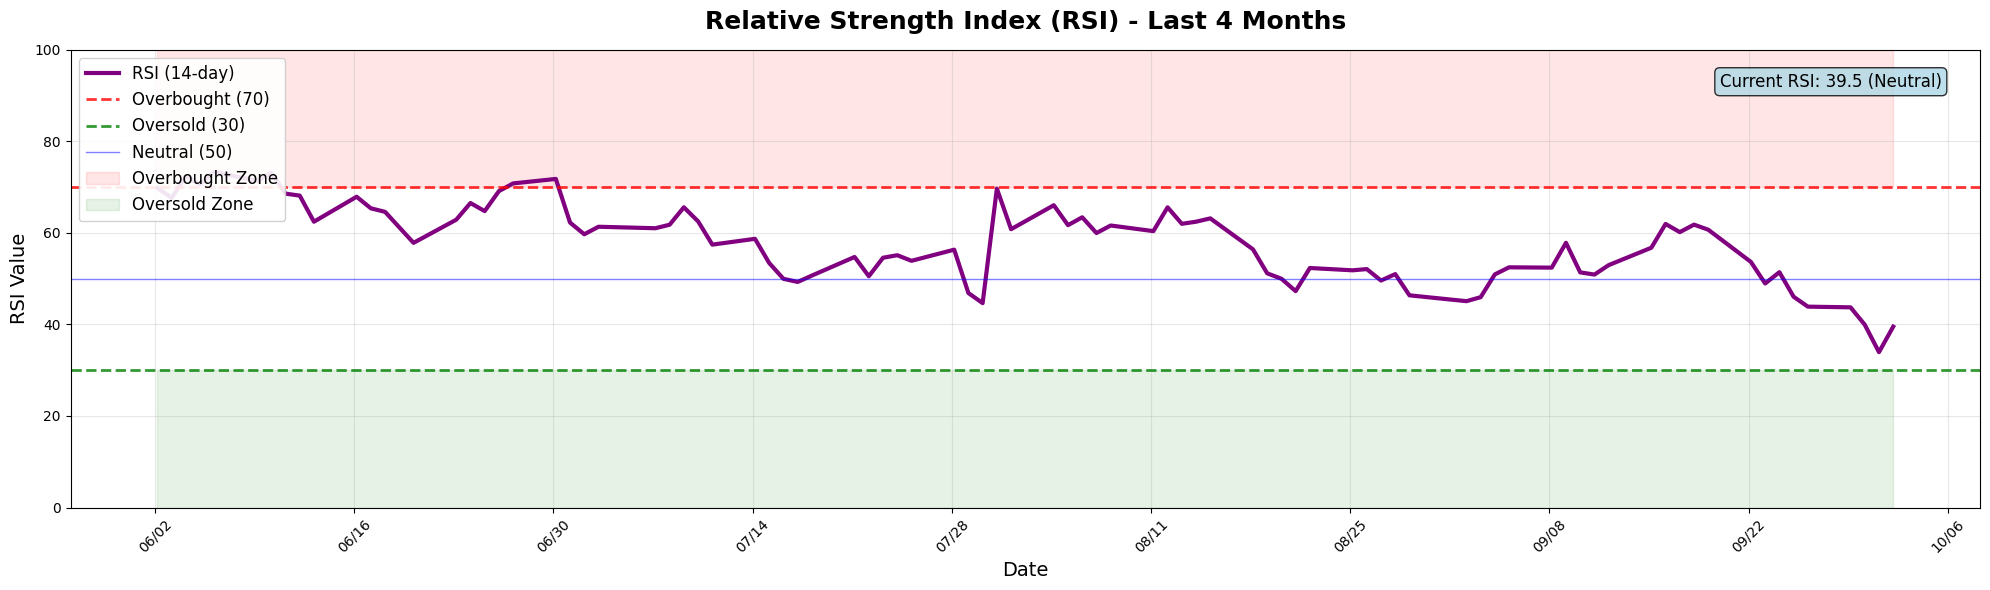

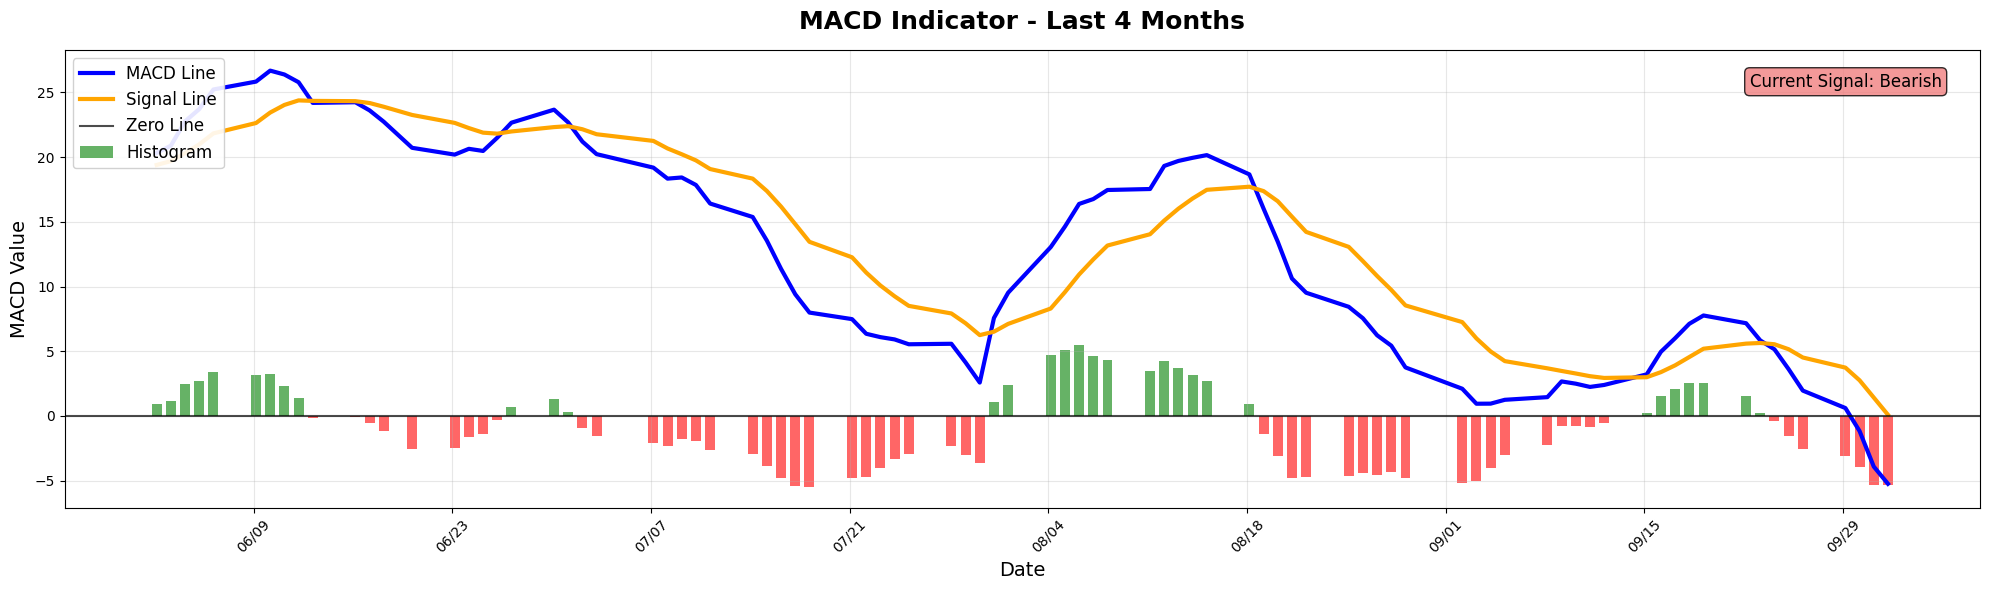


TECHNICAL ANALYSIS SUMMARY
Current Close Price: $727.05
20-day SMA: $754.87 (Below SMA)
20-day HMA: $735.27 (Below HMA)
RSI (14): 39.5 (Neutral)
MACD Signal: Bearish


In [31]:
# Calculate and display performance metrics
metrics = {
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}
print(f"Mean Squared Error (MSE): {metrics['MSE']:.4f}")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
print(f"R-squared (R2): {metrics['R2']:.4f}")

# Limit data to last 4 months for better visibility
last_4_months_start = df.index.max() - pd.DateOffset(months=4)
df_recent = df.loc[df.index >= last_4_months_start].copy()

# Add data validation
if df_recent['Predicted_Close'].isna().all():
    print("Warning: No predictions available for the recent 4-month period.")

# MUCH CLEANER Candlestick chart - separate price and volume plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12),
                               gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})

# Price chart with indicators, VWAP removed
ax1.plot(df_recent.index, df_recent['Close'], color='black', linewidth=2, label='Close Price', alpha=0.8)
ax1.plot(df_recent.index, df_recent['SMA_20'], color='purple', linewidth=2, linestyle='--', label='SMA 20', alpha=0.9)
ax1.plot(df_recent.index, df_recent['EMA_20'], color='orange', linewidth=2, linestyle='--', label='EMA 20', alpha=0.9)
ax1.plot(df_recent.index, df_recent['UPPER_BAND'], color='gray', linewidth=1.5, linestyle=':', alpha=0.7)
ax1.plot(df_recent.index, df_recent['LOWER_BAND'], color='gray', linewidth=1.5, linestyle=':', alpha=0.7)
ax1.fill_between(df_recent.index, df_recent['UPPER_BAND'], df_recent['LOWER_BAND'],
                 color='lightgray', alpha=0.2, label='Bollinger Bands')
ax1.plot(df_recent.index, df_recent['HMA_20'], color='cyan', linewidth=2, label='HMA 20', alpha=0.9) # Added HMA plot
ax1.plot(df_recent.index, df_recent['Predicted_Close'], color='red', linewidth=3, label='Predictions', alpha=0.9)

# Add model performance text on chart
textstr = f'Model Performance:\nR² = {metrics["R2"]:.3f}\nMAE = ${metrics["MAE"]:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

ax1.set_title('META Stock Price with Technical Indicators & Predictions (Last 4 Months)',
              fontsize=18, fontweight='bold', pad=20)
ax1.set_ylabel('Price ($)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('Date', fontsize=14)
ax1.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax1.xaxis.set_major_locator(WeekdayLocator(byweekday=MO, interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# Volume chart with fixed variable naming
colors = ['green' if close_price >= open_price else 'red'
          for open_price, close_price in zip(df_recent['Open'], df_recent['Close'])]
ax2.bar(df_recent.index, df_recent['Volume'], color=colors, alpha=0.7, width=0.8)
ax2.set_ylabel('Volume', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(WeekdayLocator(byweekday=MO, interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Improved next-day prediction logic with error handling
print("\n" + "="*50)
print("PREDICTION ANALYSIS")
print("="*50)
try:
    # Check if predictions exist and are not all NaN
    if 'Predicted_Close' in df.columns and not df['Predicted_Close'].isna().all():
        last_prediction = df['Predicted_Close'].dropna()
        if not last_prediction.empty:
            last_pred_date = last_prediction.index[-1]
            last_pred_value = last_prediction.iloc[-1]
            actual_price = df.loc[last_pred_date, 'Close'] if last_pred_date in df.index else None

            print(f"Most recent prediction date: {last_pred_date.date()}")
            print(f"Predicted price: ${last_pred_value:.2f}")
            if actual_price is not None:
                prediction_error = abs(actual_price - last_pred_value)
                error_percentage = (prediction_error / actual_price) * 100
                print(f"Actual price: ${actual_price:.2f}")
                print(f"Prediction error: ${prediction_error:.2f} ({error_percentage:.1f}%)")
        else:
            print("No valid predictions found in the DataFrame.")
    else:
        print("Predicted_Close column not found or contains no valid predictions.")

    # Check prediction coverage
    prediction_coverage = (df['Predicted_Close'].notna().sum() / len(df)) * 100
    print(f"Prediction coverage: {prediction_coverage:.1f}% of total data points")

except Exception as e:
    print(f"Error in prediction analysis: {e}")

# CLEAN RSI plot with enhanced styling
plt.figure(figsize=(20, 6))
plt.plot(df_recent.index, df_recent['RSI_14'], color='purple', linewidth=3, label='RSI (14-day)')
plt.axhline(70, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=2, alpha=0.8, label='Oversold (30)')
plt.axhline(50, color='blue', linestyle='-', linewidth=1, alpha=0.5, label='Neutral (50)')
plt.fill_between(df_recent.index, 70, 100, color='red', alpha=0.1, label='Overbought Zone')
plt.fill_between(df_recent.index, 0, 30, color='green', alpha=0.1, label='Oversold Zone')

# Add current RSI status
current_rsi = df_recent['RSI_14'].iloc[-1] if not df_recent['RSI_14'].empty else None
if current_rsi is not None:
    status = "Overbought" if current_rsi > 70 else "Oversold" if current_rsi < 30 else "Neutral"
    status_text = f'Current RSI: {current_rsi:.1f} ({status})'
    plt.text(0.98, 0.95, status_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.title('Relative Strength Index (RSI) - Last 4 Months', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('RSI Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=12, framealpha=0.9)
plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=MO, interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# CLEAN MACD plot with enhanced analysis
plt.figure(figsize=(20, 6))
plt.plot(df_recent.index, df_recent['MACD'], color='blue', linewidth=3, label='MACD Line')
plt.plot(df_recent.index, df_recent['MACD_Signal'], color='orange', linewidth=3, label='Signal Line')

# Color-code histogram bars
hist_colors = ['green' if x > 0 else 'red' for x in df_recent['MACD_Hist']]
plt.bar(df_recent.index, df_recent['MACD_Hist'], color=hist_colors, alpha=0.6, width=0.7, label='Histogram')
plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Zero Line')

# Add MACD signal analysis
current_macd = df_recent['MACD'].iloc[-1] if not df_recent['MACD'].empty else None
current_signal = df_recent['MACD_Signal'].iloc[-1] if not df_recent['MACD_Signal'].empty else None

if current_macd is not None and current_signal is not None:
    signal_status = "Bullish" if current_macd > current_signal else "Bearish"
    macd_text = f'Current Signal: {signal_status}'
    plt.text(0.98, 0.95, macd_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightgreen' if signal_status == 'Bullish' else 'lightcoral', alpha=0.8))

plt.title('MACD Indicator - Last 4 Months', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('MACD Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=12, framealpha=0.9)
plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=MO, interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("TECHNICAL ANALYSIS SUMMARY")
print("="*50)

# Generate technical analysis summary
try:
    rsi_current = df_recent['RSI_14'].iloc[-1]
    macd_current = df_recent['MACD'].iloc[-1]
    signal_current = df_recent['MACD_Signal'].iloc[-1]
    close_current = df_recent['Close'].iloc[-1]
    sma_current = df_recent['SMA_20'].iloc[-1]
    hma_current = df_recent['HMA_20'].iloc[-1] 

    print(f"Current Close Price: ${close_current:.2f}")
    print(f"20-day SMA: ${sma_current:.2f} ({'Above' if close_current > sma_current else 'Below'} SMA)")
    print(f"20-day HMA: ${hma_current:.2f} ({'Above' if close_current > hma_current else 'Below'} HMA)") 
    print(f"RSI (14): {rsi_current:.1f} ({'Overbought' if rsi_current > 70 else 'Oversold' if rsi_current < 30 else 'Neutral'})")
    print(f"MACD Signal: {'Bullish' if macd_current > signal_current else 'Bearish'}")

except Exception as e:
    print(f"Could not generate technical analysis summary: {e}")

print("="*50)